In [28]:
# !pip install numpy pandas scikit-learn tensorflow torch transformers spacy

### BIO Tagging

In [29]:
# !pip install chardet


In [54]:
import os
import chardet
import json


def detect_file_encoding(file_path):
    """Detect the encoding of a file."""
    with open(file_path, 'rb') as f:  # Open in binary mode
        raw_data = f.read()
        result = chardet.detect(raw_data)
        return result['encoding']

def prepare_hf_dataset(parent_folder):
    """Prepare the dataset from all year folders in the given parent folder."""
    dataset = {"tokens": [], "tags": []}
    
    # Iterate over all year folders in the parent folder
    for year_folder in os.listdir(parent_folder):
        year_path = os.path.join(parent_folder, year_folder)
        if os.path.isdir(year_path):  # Check if it's a folder
            for file in os.listdir(year_path):
                if file.endswith(".final"):
                    file_path = os.path.join(year_path, file)
                    # print(f"Processing file: {file_path}")  # Debugging
                    
                    # Detect encoding
                    try:
                        encoding = detect_file_encoding(file_path)
                        # print(f"Detected encoding for {file_path}: {encoding}")
                        with open(file_path, 'r', encoding=encoding) as f:
                            tokens, tags = [], []
                            for line in f:
                                if line.strip():  # Non-empty line
                                    parts = line.strip().split()
                                    if len(parts) == 2:
                                        word, tag = parts
                                        tokens.append(word)
                                        tags.append(tag)
                                else:  # Empty line signals end of a sentence
                                    if tokens and tags:
                                        dataset["tokens"].append(tokens)
                                        dataset["tags"].append(tags)
                                        tokens, tags = [], []  # Reset for next sentence
                            # Ensure the last sentence in the file is added
                            if tokens and tags:
                                dataset["tokens"].append(tokens)
                                dataset["tags"].append(tags)
                    except UnicodeDecodeError as e:
                        print(f"Error processing file {file_path}: {e}")
    
    return dataset

# Test the function
dataset_dir = os.getcwd() + "\\Combine_Dataset"
dataset = dict({})

for dir in os.scandir(dataset_dir):
    if dir.is_dir():
        try:
            # Attempt to prepare the dataset for this directory
            dataset[dir.name] = prepare_hf_dataset(f"{dataset_dir}\\{str(dir.name)}")
            
            # Save the dataset to a JSON file
            output_file = f"{dir.name}_dataset.json"
            with open(output_file, 'w', encoding='utf-8', errors='replace') as f:
                json.dump(dataset[dir.name], f)
            print(f"Dataset saved to {output_file}")
        
        except UnicodeDecodeError as e:
            print(f"Skipping directory {dir.name} due to encoding issue: {e}")
        except Exception as e:
            print(f"An error occurred with directory {dir.name}: {e}")

Dataset saved to dev_dataset.json
Dataset saved to test_dataset.json
Error processing file D:\Y4 T1\NLP\Project\Combine_Dataset\train\2021\2021-47-2-445-476.final: 'charmap' codec can't decode byte 0x9d in position 342: character maps to <undefined>
Dataset saved to train_dataset.json


In [55]:
import pandas as pd
train_df = pd.read_json("train_dataset.json")
test_df = pd.read_json("test_dataset.json")
dev_df = pd.read_json("dev_dataset.json")

print(f"Train Size: {len(train_df)}")
print(f"Test Size: {len(test_df)}")
print(f"Dev Size: {len(dev_df)}")

def labels_lower_to_upper(df):
    for i, tags in enumerate(df.tags):
        for tag in tags:
            if tag.islower():
                df['tags'][i][tags.index(tag)] = tag.upper()

labels_lower_to_upper(train_df)
labels_lower_to_upper(test_df)
labels_lower_to_upper(dev_df)

Train Size: 503
Test Size: 60
Dev Size: 49


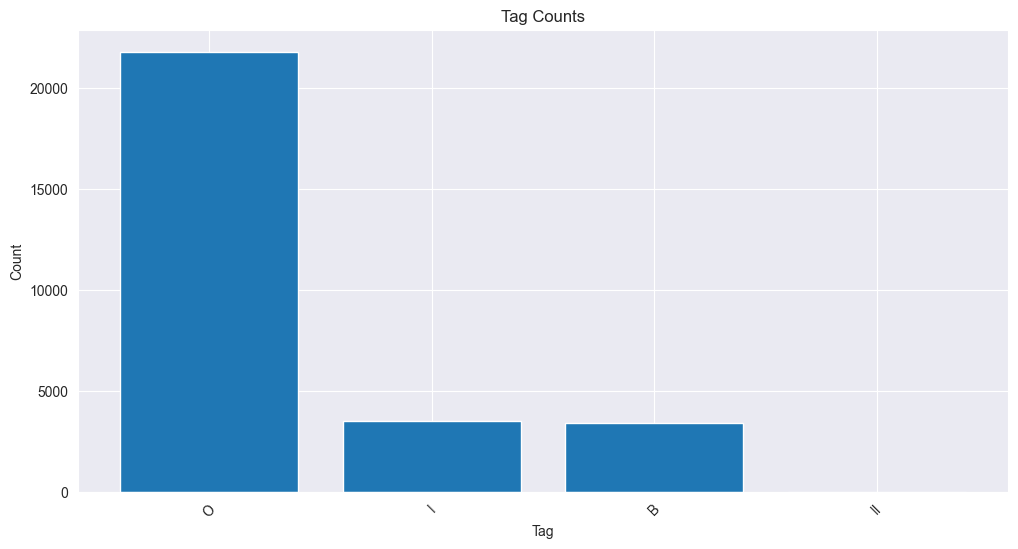

In [56]:
#plot the tags
import matplotlib.pyplot as plt
import numpy

# Count the number of occurrences of each tag
tag_counts = {}
for tags in train_df["tags"]:
    for tag in tags:
        if tag not in tag_counts:
            tag_counts[tag] = 0
        tag_counts[tag] += 1
        
# Sort the tags by count
sorted_tag_counts = dict(sorted(tag_counts.items(), key=lambda x: x[1], reverse=True))

# Plot the tag counts
plt.figure(figsize=(12, 6))
plt.bar(sorted_tag_counts.keys(), sorted_tag_counts.values())
plt.xticks(rotation=45)
plt.xlabel("Tag")
plt.ylabel("Count")
plt.title("Tag Counts")
plt.show()

In [57]:
def clean_labels(df):
    for i, tags in enumerate(df.tags):
        for tag in tags:
            if tag.islower():
                df['tags'][i][tags.index(tag)] = tag.upper()
            if len(tag) > 1:
                df['tags'][i][tags.index(tag)] = tag[0]
            if tag=='0':
                df['tags'][i][tags.index(tag)] = 'O'

clean_labels(train_df)
clean_labels(test_df)
clean_labels(dev_df)

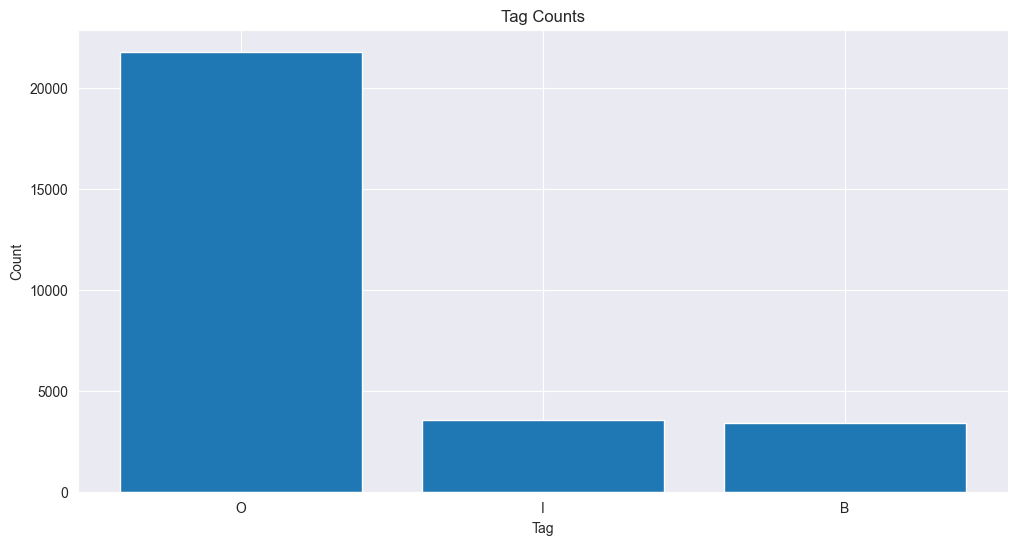

In [58]:
#plot the tags
import matplotlib.pyplot as plt
import numpy

# Count the number of occurrences of each tag
tag_counts = {}
for tags in train_df["tags"]:
    for tag in tags:
        if tag not in tag_counts:
            tag_counts[tag] = 0
        tag_counts[tag] += 1
        
# Sort the tags by count
sorted_tag_counts = dict(sorted(tag_counts.items(), key=lambda x: x[1], reverse=True))

# Plot the tag counts
plt.figure(figsize=(12, 6))
plt.bar(sorted_tag_counts.keys(), sorted_tag_counts.values())
# plt.xticks(rotation=45)
plt.xlabel("Tag")
plt.ylabel("Count")
plt.title("Tag Counts")
plt.show()

In [59]:
#print the extract number of each tags
print(sorted_tag_counts)


{'O': 21797, 'I': 3530, 'B': 3414}


### Mapping Tags to Numbers

In [60]:


BIO_MAP = {
    'O': 0,
    'B': 1,
    'I': 2
}

def convert_bio_to_numeric(bio_tags, bio_map):
    return [bio_map[tag] for tag in bio_tags]

train_df['num_tags'] = train_df['tags'].apply(lambda x: convert_bio_to_numeric(x, BIO_MAP))
test_df['num_tags'] = test_df['tags'].apply(lambda x: convert_bio_to_numeric(x, BIO_MAP))
dev_df['num_tags'] = dev_df['tags'].apply(lambda x: convert_bio_to_numeric(x, BIO_MAP))

### Convert data to hugging face format

In [61]:
# Convert the data into a Hugging Face dataset
from datasets import Dataset
dev_hugging_face_dat = Dataset.from_dict({
    "tokens": dev_df["tokens"],
    "tags": dev_df["tags"]
})

train_hugging_face_dat = Dataset.from_dict({
    "tokens": train_df["tokens"],
    "tags": train_df["tags"]
})

test_hugging_face_dat = Dataset.from_dict({
    "tokens": test_df["tokens"],
    "tags": test_df["tags"]
})



### Feature Extraction

In [62]:
def extract_features(tokens, idx):
    word = tokens[idx]
    features = {
        'word': word,  # Current word
        'is_upper': word.isupper(),  # Is the word uppercase?
        'is_title': word.istitle(),  # Is the word title case?
        'is_digit': word.isdigit(),  # Is the word a digit?
        'word_len': len(word),  # Length of the word
    }
    
    # Previous word features
    if idx > 0:
        features['prev_word'] = tokens[idx - 1]
    else:
        features['prev_word'] = "<START>"
    
    # Next word features
    if idx < len(tokens) - 1:
        features['next_word'] = tokens[idx + 1]
    else:
        features['next_word'] = "<END>"
    
    return features

def prepare_data_for_crf(dataset):
    features = []
    labels = []
    
    for example in dataset:
        tokens = example['tokens']
        tags = example['tags']
        
        # Extract features for each token
        sentence_features = [extract_features(tokens, idx) for idx in range(len(tokens))]
        features.append(sentence_features)
        labels.append(tags)
    
    return features, labels


In [63]:
# Example: Assuming train_dataset is the Hugging Face dataset
train_features, train_labels = prepare_data_for_crf(train_hugging_face_dat)
test_features, test_labels = prepare_data_for_crf(test_hugging_face_dat)


In [64]:
import sklearn_crfsuite
from sklearn_crfsuite import metrics

# Initialize the CRF model
crf = sklearn_crfsuite.CRF(
    algorithm='pa',  # Passive-Aggressive optimization
    max_iterations=100,
    all_possible_transitions=True
)



# Train the model
crf.fit(train_features, train_labels)


CRF(algorithm='pa', all_possible_transitions=True, max_iterations=100)

In [65]:
# Make predictions on the test set
predicted_labels = crf.predict(test_features)

# Evaluate the model's performance
print(metrics.flat_classification_report(test_labels, predicted_labels))


              precision    recall  f1-score   support

           B       0.56      0.54      0.55       451
           I       0.72      0.66      0.69       488
           O       0.91      0.93      0.92      3205

    accuracy                           0.85      4144
   macro avg       0.73      0.71      0.72      4144
weighted avg       0.85      0.85      0.85      4144



In [66]:
# Hyperparameter tuning example (you can use grid search for this)
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(train_features, train_labels)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

In [67]:
def predict_tags(tokens):
    features = [extract_features(tokens, idx) for idx in range(len(tokens))]  # Extract features for the new tokens
    predicted_tags = crf.predict([features])  # Get predicted tags
    return predicted_tags[0]

# Example usage
new_tokens = ["This", "paper", "aim", "to", "solve", "machine", "translation", "Tagging", "problem", "using", "neural", "networks"]
predicted_tags = predict_tags(new_tokens)
print(list(zip(new_tokens, predicted_tags)))


[('This', 'O'), ('paper', 'O'), ('aim', 'O'), ('to', 'O'), ('solve', 'O'), ('machine', 'B'), ('translation', 'I'), ('Tagging', 'I'), ('problem', 'O'), ('using', 'O'), ('neural', 'B'), ('networks', 'I')]


In [68]:
# Make predictions on the test set
predicted_labels = crf.predict(test_features)

# Evaluate the model's performance
print(metrics.flat_classification_report(test_labels, predicted_labels))


              precision    recall  f1-score   support

           B       0.66      0.54      0.60       451
           I       0.73      0.68      0.70       488
           O       0.91      0.94      0.92      3205

    accuracy                           0.87      4144
   macro avg       0.77      0.72      0.74      4144
weighted avg       0.86      0.87      0.86      4144



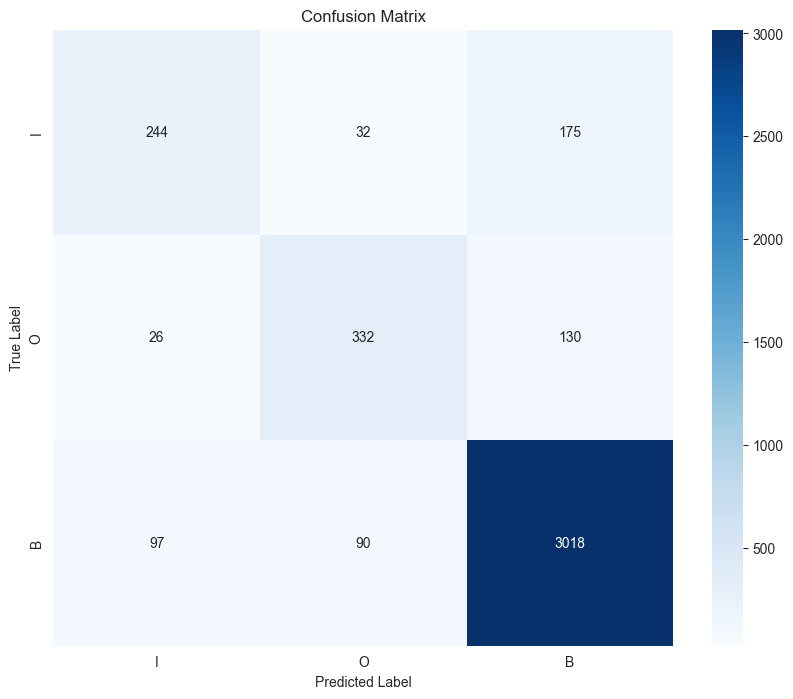

In [69]:
# plot confusion matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes):
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a DataFrame from the confusion matrix
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
# Get the unique tags
unique_tags = list(set(tag for tags in test_labels for tag in tags))

# Plot the confusion matrix
plot_confusion_matrix([tag for tags in test_labels for tag in tags], [tag for tags in predicted_labels for tag in tags], unique_tags)



In [70]:
# save the model as pkl
import pickle

with open("crf_ner_model.pkl", "wb") as f:
    pickle.dump(crf, f)
    



## Standard LSTM Model

Epoch 1/10, Loss: 1.1150
Epoch 2/10, Loss: 0.7680
Epoch 3/10, Loss: 0.6649
Epoch 4/10, Loss: 0.5946
Epoch 5/10, Loss: 0.5399
Epoch 6/10, Loss: 0.4870
Epoch 7/10, Loss: 0.4430
Epoch 8/10, Loss: 0.4047
Epoch 9/10, Loss: 0.3677
Epoch 10/10, Loss: 0.3394
Classification Report:
              precision    recall  f1-score   support

           B       0.53      0.36      0.43       235
           I       0.67      0.56      0.61       244
           O       0.85      0.92      0.88      1397

    accuracy                           0.80      1876
   macro avg       0.68      0.61      0.64      1876
weighted avg       0.79      0.80      0.79      1876

Accuracy: 0.8033
F1 Score: 0.7911


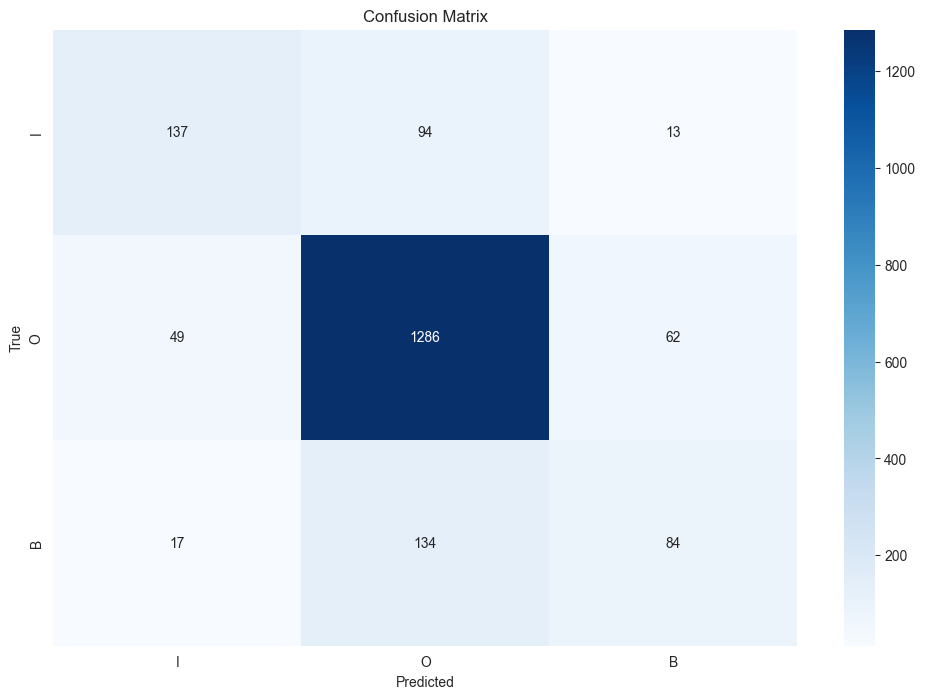

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset as HFDataset
import numpy as np

# Preprocessing utilities
class SequenceDataset(Dataset):
    def __init__(self, sentences, tags, word2idx, tag2idx, max_len):
        self.sentences = sentences
        self.tags = tags
        self.word2idx = word2idx
        self.tag2idx = tag2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        tag_seq = self.tags[idx]

        # Padding and converting to indices
        sentence_padded = [self.word2idx.get(word, self.word2idx["<UNK>"]) for word in sentence]
        tag_padded = [self.tag2idx[tag] for tag in tag_seq]

        sentence_padded = sentence_padded[:self.max_len] + [self.word2idx["<PAD>"]] * (self.max_len - len(sentence_padded))
        tag_padded = tag_padded[:self.max_len] + [self.tag2idx["<PAD>"]] * (self.max_len - len(tag_padded))

        return torch.tensor(sentence_padded, dtype=torch.long), torch.tensor(tag_padded, dtype=torch.long)

# Model Definition
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim):
        super(LSTMTagger, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentences):
        embeddings = self.embedding(sentences)
        lstm_out, _ = self.lstm(embeddings)
        logits = self.fc(lstm_out)
        return logits

# Preprocessing function
def preprocess_data(dataset, max_len):
    sentences = dataset["tokens"]
    tags = dataset["tags"]

    vocab = {word for sentence in sentences for word in sentence}
    tags_set = {tag for tag_seq in tags for tag in tag_seq}

    word2idx = {word: idx + 2 for idx, word in enumerate(vocab)}
    word2idx["<PAD>"] = 0
    word2idx["<UNK>"] = 1

    tag2idx = {tag: idx + 1 for idx, tag in enumerate(tags_set)}
    tag2idx["<PAD>"] = 0

    return sentences, tags, word2idx, tag2idx

# Training function
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for sentences, tags in train_loader:
        sentences, tags = sentences.to(device), tags.to(device)
        optimizer.zero_grad()
        outputs = model(sentences)
        outputs = outputs.view(-1, outputs.shape[-1])
        tags = tags.view(-1)
        loss = criterion(outputs, tags)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Evaluation function
def evaluate_model(model, test_loader, tag2idx, idx2tag, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for sentences, tags in test_loader:
            sentences, tags = sentences.to(device), tags.to(device)
            outputs = model(sentences)
            predicted = torch.argmax(outputs, dim=-1)
            for true, pred in zip(tags, predicted):
                true = true.cpu().numpy()
                pred = pred.cpu().numpy()
                for t, p in zip(true, pred):
                    if t != tag2idx["<PAD>"]:
                        y_true.append(idx2tag[t])
                        y_pred.append(idx2tag[p])

    # Check if predictions were made
    if not y_true or not y_pred:
        print("No predictions made. Ensure the test dataset is not empty and preprocessing is correct.")
        return

    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    # Accuracy and F1 Score
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Generate confusion matrix
    labels = [tag for tag in tag2idx if tag != "<PAD>"]
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Plot confusion matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Function to predict tags for a new sentence
def predict_tags(tokens):
    model.eval()
    features = [word2idx.get(word, word2idx["<UNK>"]) for word in tokens]
    features_padded = features + [word2idx["<PAD>"]] * (MAX_LEN - len(features))
    input_tensor = torch.tensor([features_padded], dtype=torch.long).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        predicted_tags_idx = torch.argmax(output, dim=-1).cpu().numpy()[0]
        predicted_tags = [idx2tag[idx] for idx in predicted_tags_idx[:len(tokens)]]
    
    return list(zip(tokens, predicted_tags))

# Dataset preparation
train_hugging_face_dat = HFDataset.from_dict({
    "tokens": train_df["tokens"],
    "tags": train_df["tags"]
})

test_hugging_face_dat = HFDataset.from_dict({
    "tokens": test_df["tokens"],
    "tags": test_df["tags"]
})

MAX_LEN = 50
BATCH_SIZE = 32
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
EPOCHS = 10

train_sentences, train_tags, word2idx, tag2idx = preprocess_data(train_hugging_face_dat, MAX_LEN)
test_sentences, test_tags, _, _ = preprocess_data(test_hugging_face_dat, MAX_LEN)

idx2tag = {idx: tag for tag, idx in tag2idx.items()}

train_dataset = SequenceDataset(train_sentences, train_tags, word2idx, tag2idx, MAX_LEN)
test_dataset = SequenceDataset(test_sentences, test_tags, word2idx, tag2idx, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMTagger(len(word2idx), len(tag2idx), EMBEDDING_DIM, HIDDEN_DIM).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=tag2idx["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
for epoch in range(EPOCHS):
    train_loss = train_model(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {train_loss:.4f}")

# Evaluation
evaluate_model(model, test_loader, tag2idx, idx2tag, device)


In [48]:
def enforce_b_i_rules_postprocess(predicted_tags):
    """
    Ensure B-I rules:
    - I tags must follow a valid B tag of the same type.
    - If I appears incorrectly, convert it to B.
    """
    corrected_tags = []
    prev_b_tag = None  # Track previous valid B tag

    for tag in predicted_tags:
        if tag.startswith("I"):
            # Fix I if it doesn't follow a valid B tag
            if prev_b_tag is None or prev_b_tag[2:] != tag[2:]:
                corrected_tags.append("B" + tag[1:])
                prev_b_tag = corrected_tags[-1]
            else:
                corrected_tags.append(tag)
        else:
            corrected_tags.append(tag)
            prev_b_tag = tag if tag.startswith("B") else None

    return corrected_tags

def predict_tags(tokens):
    model.eval()
    features = [word2idx.get(word, word2idx["<UNK>"]) for word in tokens]
    features_padded = features + [word2idx["<PAD>"]] * (MAX_LEN - len(features))
    input_tensor = torch.tensor([features_padded], dtype=torch.long).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        predicted_tags_idx = torch.argmax(output, dim=-1).cpu().numpy()[0]
        predicted_tags = [idx2tag[idx] for idx in predicted_tags_idx[:len(tokens)]]

    # Enforce B-I rules on predictions
    corrected_tags = enforce_b_i_rules_postprocess(predicted_tags)
    
    return list(zip(tokens, corrected_tags))


In [49]:
# Predict tags for a new sentence
new_tokens = ["This", "is", "natural", "language", "processing", "tagging", "problem"]
predicted_tags = predict_tags(new_tokens)
print("Predictions:", predicted_tags)


Predictions: [('This', 'O'), ('is', 'O'), ('natural', 'O'), ('language', 'B'), ('processing', 'I'), ('tagging', 'I'), ('problem', 'O')]


In [50]:
import pickle

# Define a path to save the model
MODEL_PATH = "lstm_ner_model.pkl"

# Create a dictionary with the model and metadata
model_data = {
    'model_state_dict': model.state_dict(),
    'word2idx': word2idx,
    'tag2idx': tag2idx,
    'idx2tag': idx2tag,
    'embedding_dim': EMBEDDING_DIM,
    'hidden_dim': HIDDEN_DIM,
    'max_len': MAX_LEN
}

# Save with pickle
with open(MODEL_PATH, 'wb') as f:
    pickle.dump(model_data, f)

print(f"Model saved as {MODEL_PATH}")


Model saved as lstm_ner_model.pkl


In [51]:
import numpy as np

#print numpy version
print(np.__version__)

1.26.4


In [52]:
import sys
print(sys.path)


['C:\\Program Files\\JetBrains\\PyCharm 2023.2.3\\plugins\\python\\helpers-pro\\jupyter_debug', 'C:\\Program Files\\JetBrains\\PyCharm 2023.2.3\\plugins\\python-ce\\helpers\\pydev', 'D:\\Y4 T1', 'C:\\Users\\Solita Pun\\AppData\\Local\\Programs\\Python\\Python311\\python311.zip', 'C:\\Users\\Solita Pun\\AppData\\Local\\Programs\\Python\\Python311\\DLLs', 'C:\\Users\\Solita Pun\\AppData\\Local\\Programs\\Python\\Python311\\Lib', 'C:\\Users\\Solita Pun\\AppData\\Local\\Programs\\Python\\Python311', 'D:\\Y3 T8\\ML\\Labs\\Support Vector Machine\\.venv', '', 'D:\\Y3 T8\\ML\\Labs\\Support Vector Machine\\.venv\\Lib\\site-packages', 'D:\\Y3 T8\\ML\\Labs\\Support Vector Machine\\.venv\\Lib\\site-packages\\win32', 'D:\\Y3 T8\\ML\\Labs\\Support Vector Machine\\.venv\\Lib\\site-packages\\win32\\lib', 'D:\\Y3 T8\\ML\\Labs\\Support Vector Machine\\.venv\\Lib\\site-packages\\Pythonwin']


In [53]:
# Save the model along with word2idx and tag2idx
import pickle

# Assuming `model`, `word2idx`, and `tag2idx` are already defined
with open("lstm_model.pkl", "wb") as f:
    pickle.dump({
        "state_dict": model.state_dict(),
        "word2idx": word2idx,
        "tag2idx": tag2idx,
    }, f)


## BiLSTM Model

# LSTM New